# Validation for Multiview Spectral Clustering
References: <br> 
[1] Abhishek Kumar and Hal Daume. A Co-training Approach for Multiview Spectral Clustering. In International Conference on Machine Learning, 2011

In [1]:
import numpy as np
import scipy as scp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import matplotlib.pyplot as plt


#### Loading in the synthetic dataset used by Daume and Kumar in their implementation of Multi-view Spectral Clustering

In [2]:
def get_synth_data():
    datafile1 = './Data/view1.csv'
    datafile2 = './Data/view2.csv'
    datafile3 = './Data/view3.csv'
    labelfile = './Data/labels.csv'

    v1_data = np.loadtxt(datafile1, delimiter = ',')
    v2_data = np.loadtxt(datafile2, delimiter = ',')
    v3_data = np.loadtxt(datafile3, delimiter = ',')
    labels = np.loadtxt(labelfile, delimiter = ',')
    v_data = [v1_data, v2_data, v3_data]
    
    return v_data, labels


In [3]:
v_data, labels = get_synth_data()

#### Implementing both Single-view and Multi-view spectral clustering and helper functions

In [4]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists  / (2 * np.median(sq_dists))
    sims = np.exp(-norm_dists)
    
    return sims
    
def sym(S_mat):
    mat =  (S_mat + np.transpose(S_mat)) / 2.0
    return mat

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.sqrt(np.linalg.inv(np.abs(D_mat))) 
    laplacian = D_alt @ X_mat @ D_alt
    laplacian = sym(laplacian)
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(np.real(e_vals))[-k:]
    e_vecs = np.real(e_vecs[:,indices])
    return e_vecs

In [5]:
def single_spectral(U_mats, labels, k=2):

    #Row normalize 
    U_norm = np.linalg.norm(U_mats, axis = 1).reshape((-1, 1))
    U_norm[U_norm == 0] = 1
    V_mats = U_mats/ U_norm 
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(V_mats)
    nmi = nmi_score(clusters, labels)
    return nmi

In [6]:
def multiview_spectral(v_data, labels, k=2, num_iter = 10):
    #Compute the similarities matrices
    sims = [gaussian_sim(dat) for dat in v_data]
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in sims]
    
    nmi_vals = list()
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        
        eig_sums = [u_mat @ np.transpose(u_mat) for u_mat in U_mats]
        U_sum = np.sum(np.array(eig_sums), axis=0)
        
        new_sims = list()
        
        for view in range(len(v_data)):
            mat1 = sims[view] @ (U_sum - U_mats[view] @ np.transpose(U_mats[view]))
            new_sims.append(sym(mat1))
        U_mats = [comp_eigs(sim, k) for sim in new_sims]  
        
        #Compute nmi for each view per iteration
        nmi_set = list()
        for ind in range(len(v_data)):
            nmi = single_spectral(U_mats[ind], labels, k)
            nmi_set.append(nmi)
        nmi_vals.append(nmi_set)  
        
    #Row normalize 
    for view in range(len(v_data)):
        U_norm = np.linalg.norm(U_mats[view], axis = 1).reshape((-1, 1))
        U_norm[U_norm == 0] = 1
        U_mats[view] /= U_norm 
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)    
    kmeans = KMeans(n_clusters=k, n_init=100)
    clusters = kmeans.fit_predict(V_mat)
    return clusters, nmi_vals
    

#### Running my implementation of Multi-view spectral clustering
Here, I use the Single-view spectral clustering algorithm at each iteration of the Multi-view algorithm to cluster each view separately and evaluate the NMI between these clusters and the true cluster labels.

In [7]:
# Run for 10 iterations
nmi_list = list()
for ind in range(10):
    clusters, nmi_vals = multiview_spectral(v_data, labels, k=2)
    nmi_list.append(nmi_vals)

In [8]:
nmi_vals = np.array(nmi_list).transpose()
nmi_ave = np.mean(nmi_vals, axis=2)
nmi_std = np.std(nmi_vals, axis=2)

#### Performance of my implementation of Multi-view Spectral Clustering averaged over 10 runs

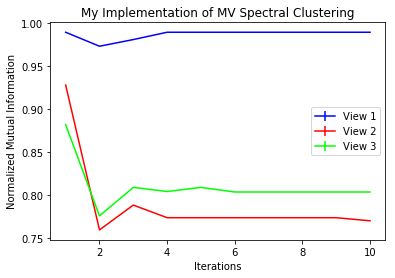

In [11]:
x_vals = list(range(1, 11))
plt.errorbar(x_vals, nmi_ave[0], yerr=nmi_std[0], color='b')
plt.errorbar(x_vals, nmi_ave[1], yerr=nmi_std[1], color='r')
plt.errorbar(x_vals, nmi_ave[2], yerr=nmi_std[2], color='lime')
plt.xlabel('Iterations')
plt.ylabel('Normalized Mutual Information')
plt.legend(['View 1','View 2','View 3'])
plt.title('My Implementation of MV Spectral Clustering')
plt.show()

#### Displaying the results of the authors' implementation of the algorithm

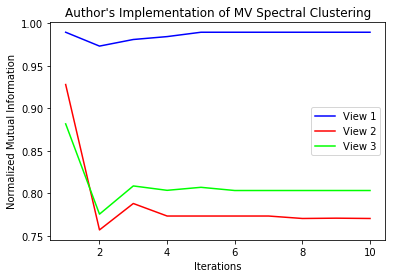

In [12]:
# Results produced by code from the paper
resultfile = './Data/results.csv'
paper_results = np.loadtxt(resultfile, delimiter = ',')
paper_results = np.transpose(paper_results)
x_vals = list(range(1,11))
plt.plot(x_vals, paper_results[0], 'b' , x_vals, paper_results[1], 'r', 
         x_vals, paper_results[2], 'lime')
plt.xlabel('Iterations')
plt.ylabel('Normalized Mutual Information')
plt.legend(['View 1','View 2','View 3'])
plt.title('Author\'s Implementation of MV Spectral Clustering')
plt.show()

#### Displaying all three views of the synthetic data

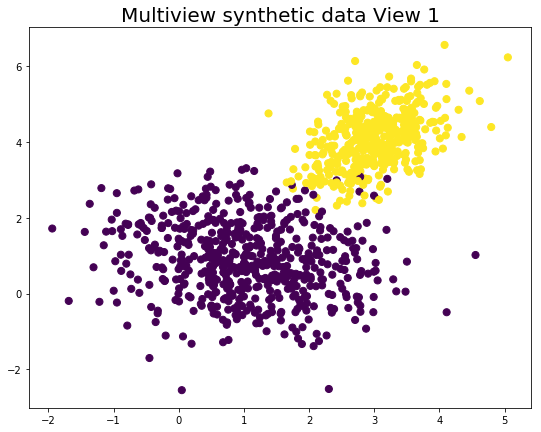

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview synthetic data View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

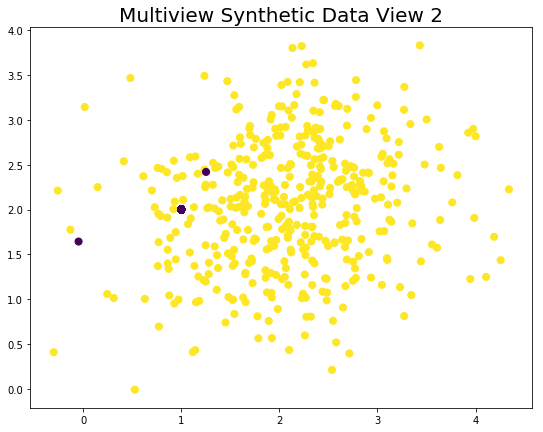

In [14]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=clusters,s=dot_size, cmap=cmap)

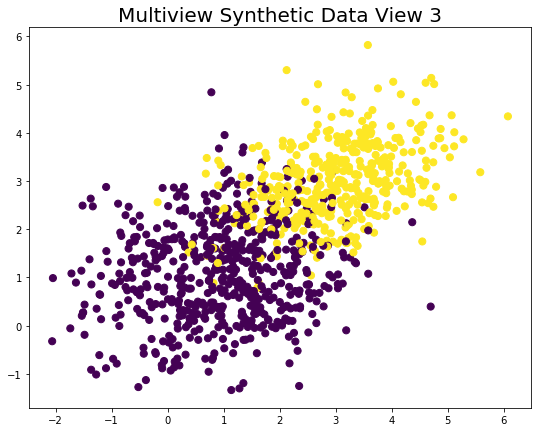

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=clusters,s=dot_size, cmap=cmap)